**INSTALL AND IMPORTS**

In [1]:
!pip install xgboost scikit-learn pandas numpy

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from datetime import datetime

**LOAD DATA**

In [2]:
df = pd.read_csv('leads_cleaned.csv')
print(df.shape)
df.head()

(54294, 42)


,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,round_b,round_c,round_d,round_e,round_f,round_g,round_h,converted,intent,text_for_similarity
0,/organization/waywire,#waywire,http://www.waywire.com,|entertainment|politics|social media|news|,news,1750000,acquired,usa,ny,new york city,...,0,0,0,0,0,0,0,1,1,#waywire |entertainment|politics|social media|...
1,/organization/tv-communications,&tv communications,http://enjoyandtv.com,|games|,games,4000000,operating,usa,ca,los angeles,...,0,0,0,0,0,0,0,1,0,&tv communications |games| games
2,/organization/rock-your-paper,'rock' your paper,http://www.rockyourpaper.org,|publishing|education|,publishing,40000,operating,est,NaN,tallinn,...,0,0,0,0,0,0,0,0,0,'rock' your paper |publishing|education| publi...
3,/organization/in-touch-network,(in)touch network,http://www.InTouchNetwork.com,|electronics|guides|coffee|restaurants|music|i...,electronics,1500000,operating,gbr,NaN,london,...,0,0,0,0,0,0,0,1,0,(in)touch network |electronics|guides|coffee|r...
4,/organization/r-ranch-and-mine,-r- ranch and mine,NaN,|tourism|entertainment|games|,tourism,60000,operating,usa,tx,dallas,...,0,0,0,0,0,0,0,0,1,-r- ranch and mine |tourism|entertainment|game...


**FEATURE ENGINEERING**

In [3]:
# Company age
current_year = datetime.now().year
df['company_age'] = current_year - df['founded_year'].fillna(current_year).astype(int)

# Time since last funding (in years)
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], errors='coerce')
df['time_since_last_funding'] = (pd.Timestamp.now() - df['last_funding_at']).dt.days / 365.25
df['time_since_last_funding'] = df['time_since_last_funding'].fillna(df['time_since_last_funding'].median())

# Time to first funding (in years)
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
df['time_to_first_funding'] = (df['first_funding_at'] - df['founded_at']).dt.days / 365.25
df['time_to_first_funding'] = df['time_to_first_funding'].fillna(df['time_to_first_funding'].median())

**HANDLE RARE CATEGORIES**

In [4]:
def group_rare(series, min_count=100):
    freq = series.value_counts()
    return series.apply(lambda x: x if freq[x] >= min_count else 'other')

for col in ['city', 'market']:
    if col in df.columns:
        df[col] = group_rare(df[col].fillna(''), min_count=100)

**TF-IDF FEATURES**

In [5]:
df['text_features'] = df['category_list'].fillna('') + ' ' + df['market'].fillna('')

tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(df['text_features'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])])

**PREPARE FEATURES AND TARGET**

In [6]:
# Funding round columns
funding_cols = [
    'seed','venture','equity_crowdfunding','undisclosed','convertible_note','debt_financing',
    'angel','grant','private_equity','post_ipo_equity','post_ipo_debt','secondary_market',
    'product_crowdfunding','round_a','round_b','round_c','round_d','round_e','round_f','round_g','round_h'
]
funding_cols = [col for col in funding_cols if col in df.columns]

# Final feature list
features = [
    'market', 'category_list', 'funding_rounds', 'status',
    'country_code', 'state_code', 'region', 'city', 'company_age',
    'time_since_last_funding', 'time_to_first_funding'
] + funding_cols

# Define categorical features
cat_features = ['market', 'category_list', 'status', 'country_code', 'state_code', 'region', 'city']


X = df[features].copy()
y = df['converted']

# Fill missing values: categorical columns with '', numeric columns with 0
for col in cat_features:
    X[col] = X[col].fillna('').astype(str)
for col in X.columns:
    if col not in cat_features:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

# One-hot encode categorical features
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat = ohe.fit_transform(X[cat_features])
X_num = X.drop(columns=cat_features).astype(float).values

# Combine with TF-IDF features
X_all = np.hstack([X_cat, X_num, tfidf_df.values])

In [7]:
tfidf_feature_names = [f'tfidf_{i}' for i in range(tfidf_df.shape[1])]
tfidf_features = pd.DataFrame(tfidf_df.values, columns=tfidf_feature_names)

preprocessed_df = pd.concat([X.reset_index(drop=True), tfidf_features], axis=1)
preprocessed_df['converted'] = y.values

# Save to CSV
preprocessed_df.to_csv('lead_scoring.csv', index=False)

**TRAIN/TEST SPLIT**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

**TRAIN XGBOOST**

In [9]:
model = XGBClassifier(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:32:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

**MODEL EVALUATION**

In [10]:
y_pred_proba = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

ROC AUC: 0.877975377559558
Accuracy: 0.7881020351781932
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      5943
           1       0.77      0.76      0.76      4916

    accuracy                           0.79     10859
   macro avg       0.79      0.79      0.79     10859
weighted avg       0.79      0.79      0.79     10859



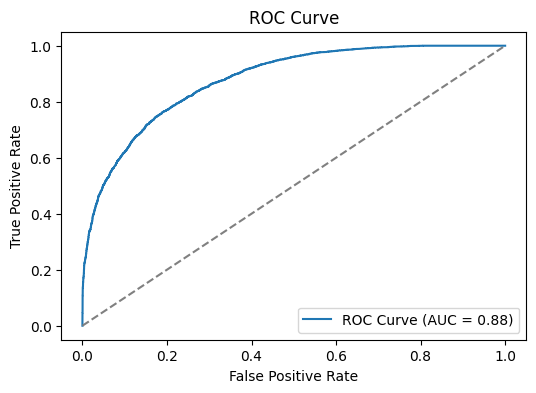

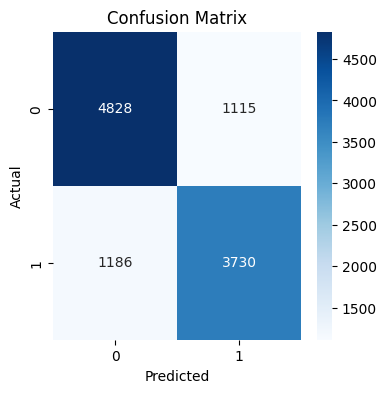

In [11]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_proba)))
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**MODEL INFERENCE( LEAD SCORE: 0-100)**

In [12]:
X_new_cat = ohe.transform(X[cat_features].iloc[:5])
X_new_num = X.drop(columns=cat_features).iloc[:5].astype(float).values
X_new_tfidf = tfidf.transform(df['text_features'].iloc[:5]).toarray()
X_new = np.hstack([X_new_cat, X_new_num, X_new_tfidf])

probs = model.predict_proba(X_new)[:,1]
lead_scores = (probs * 100).round(2)
print("Lead scores (0-100):", lead_scores)

Lead scores (0-100): [35.7  78.3   1.46  5.22 15.25]


**SAVE MODELS**

In [13]:
joblib.dump(model, 'lead_xgb_model.pkl')
joblib.dump(ohe, 'lead_ohe.pkl')
joblib.dump(tfidf, 'lead_tfidf.pkl')

['lead_tfidf.pkl']